# **Optimizing Store Performance: A Demand Forecasting Analysis**
## Introduction
### Dataset Overview
- A store chain's 5-year data includes information on 10 different stores and 50 different products.
- The data set covers the period between 01-01-2013 and 31-12-2017.

### Problem
- It is desired to create a 3-month demand forecasting model for 10 different stores and 50 different products of a chain of stores.
- Afterwards, it is desired to reduce the data set to weekly and create a demand forecasting model for 2017.

### Variables
- date: Date of sales data (No holiday effects or store closures)
- store: Store ID Unique number for each store.
- item: Item ID Unique number for each item.
- sales: Number of items sold, Number of items sold from a particular store on a given date

## 1. Importing Libraries
Import essential libraries and tools required for data analysis, visualization, and demand forecastings, such as pandas, matplotlib, and seaborn, and forecasting-specific tools such as LightGBM, SARIMAX, and ARIMA. This ensures all necessary tools are available for analysis and modeling.

In [26]:
# Setup Libraries
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.filterwarnings('ignore')

## 2. Load Dataset

Load and merge the training and testing data to prepare it for analysis.

In [27]:
train = pd.read_csv('demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False)
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [28]:
print("Size of train set",train.shape)
print("Size of test set:",test.shape)

#Removing the extra column 'id'
df.drop(['id'],inplace=True,axis=1)
df.columns

Size of train set (913000, 4)
Size of test set: (45000, 4)


Index(['date', 'store', 'item', 'sales'], dtype='object')

## 3. Basic Exploratory Data Analysis

Likely to gain initial insights into data distribution, patterns, or missing values.
1. Collecting Statistics of Variables: Summary statistics (like mean, min, max, etc.) provide insights into the overall distribution of each variable, helping to identify central tendencies and outliers in the data.
2. Sale Statistics in store-product breakdown: calculates various sales statistics (sum, mean, median, and standard deviation) for each unique combination of store and item.
3. Line Plot of Sales Over Time: This shows trends or seasonality in sales across dates.
4. Correlation Heatmap: Visualizes relationships between variables, highlighting correlations.
5. Pairplot of Store, Item, and Sales: Shows scatter plots and distributions to explore variable relationships.

In [29]:
# Data Range
print("Date range:", df["date"].min(), "to", df["date"].max())

Date range: 2013-01-01 00:00:00 to 2018-03-31 00:00:00


In [30]:
# Sales distribution
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [31]:
# Number of stores
df["store"].nunique()

10

In [32]:
# Number of products
df["item"].nunique() 

50

In [33]:
# Number of products in each store
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [34]:
# Sales statistics in store-product breakdown
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

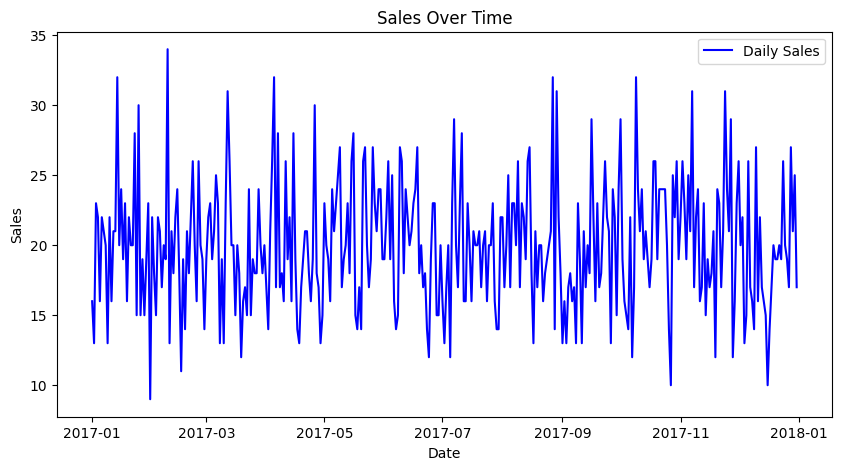

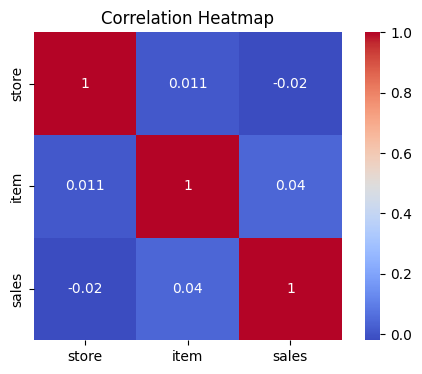

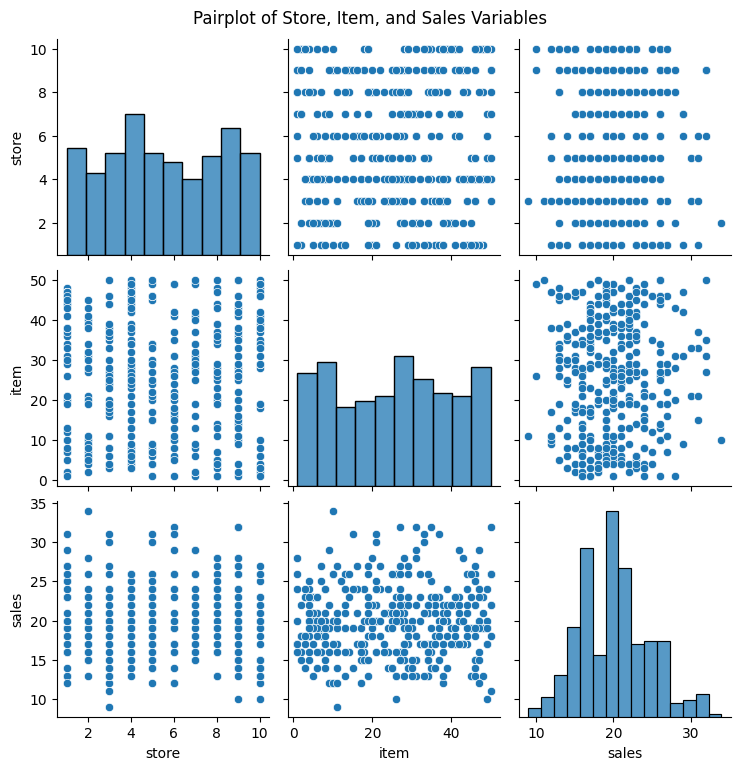

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Re-create sample dataset
np.random.seed(0)
dates = pd.date_range(start="2017-01-01", end="2017-12-31", freq="D")
data = {
    'date': dates,
    'store': np.random.choice(range(1, 11), len(dates)),
    'item': np.random.choice(range(1, 51), len(dates)),
    'sales': np.random.poisson(lam=20, size=len(dates))
}
df = pd.DataFrame(data)

# Code to create each visualization

# 1. Line Plot of Sales Over Time
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['sales'], label='Daily Sales', color='blue')
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(6, 4))
correlation = df[['store', 'item', 'sales']].corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()

# 3. Pairplot of Store, Item, and Sales
sns.pairplot(df[['store', 'item', 'sales']])
plt.suptitle("Pairplot of Store, Item, and Sales Variables", y=1.02)
plt.show()

## 4. Feature Engineering

Creates features through code, possibly transforming time-based data, aggregating sales, or adding seasonal indicators.

In [35]:
# Generating date and time parameters from given date
df['month'] = df.date.dt.month
df['day_of_month'] = df.date.dt.day
df['day_of_year'] = df.date.dt.dayofyear 
df['week_of_year'] = df.date.dt.isocalendar().week
df['day_of_week'] = df.date.dt.dayofweek
df['year'] = df.date.dt.year
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int) 

df.head()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,1,5,5,1,5,2013,1,0,0


In [36]:
# Sales statistics in store-item-month breakdown
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [37]:
# DEALING WITH RAMDOM NOISE
# For small datasets like this dataset, random noise can be added to the values ​​to prevent overfitting.
# Here I will add Gaussian random noise, which is normally distributed with 1 standard deviation and 0 mean.
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

#Lag/Shifted Features (Delays)
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df.head(10)

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,1,5,5,1,5,2013,1,0,0
5,2013-01-06,1,1,12.0,1,6,6,1,6,2013,1,0,0
6,2013-01-07,1,1,10.0,1,7,7,2,0,2013,0,0,0
7,2013-01-08,1,1,9.0,1,8,8,2,1,2013,0,0,0
8,2013-01-09,1,1,12.0,1,9,9,2,2,2013,0,0,0
9,2013-01-10,1,1,9.0,1,10,10,2,3,2013,0,0,0


In [38]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [39]:
#Moving Average Features
def moving_average_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

df = moving_average_features(df, [365, 546, 730])

In [40]:
#Exponentially Weighted Average Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

## 5. Data Encoding

Applies encoding techniques to categorical data such as stores or items.

In [41]:
#Checking for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 958000 entries, 0 to 44999
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   date                         958000 non-null  datetime64[ns]
 1   store                        958000 non-null  int64         
 2   item                         958000 non-null  int64         
 3   sales                        913000 non-null  float64       
 4   month                        958000 non-null  int32         
 5   day_of_month                 958000 non-null  int32         
 6   day_of_year                  958000 non-null  int32         
 7   week_of_year                 958000 non-null  UInt32        
 8   day_of_week                  958000 non-null  int32         
 9   year                         958000 non-null  int32         
 10  is_wknd                      958000 non-null  int32         
 11  is_month_start               958

In [42]:
#One-Hot Encoding
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

In [43]:
#Converting sales to log(1+sales)
df['sales'] = np.log1p(df["sales"].values)

## 6. LightGBM Model

In this section, trained a LightGBM model for demand forecasting. Multiple steps for model training, tuning, and evaluation, likely including parameter selection and result interpretation.

In [44]:
# Train data set until the beginning of 2017 (end of 2016)
train = df.loc[(df["date"] < "2017-01-01"), :]

# First 3 months of 2017 validation set
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

# Independent variables
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [45]:
# Selecting the dependent variable for the train set
Y_train = train['sales']

# Selecting the argument for the train set
X_train = train[cols]

# choosing the dependent variable for the validation set
Y_val = val['sales']

# selecting the independent variable for the validation set
X_val = val[cols] 

# Checking the shapes
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 94), (45000,), (45000, 94))

In [46]:
# Custom Cost Function
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [73]:
# LightGBM parameters
lgb_params = {
    'metric': 'mae',                 
    'num_leaves': 10,                
    'learning_rate': 0.02,           
    'feature_fraction': 0.8,         
    'max_depth': 5,                  
    'verbose': -1,                   
    'nthread': -1,
    'early_stopping_round': 100                    
}

In [81]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(
    params=lgb_params,
    train_set=lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    num_boost_round=1000,                
    feval=lgbm_smape,                    
)
# Prediction
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration, predict_disable_shape_check=True)

# SMAPE calculation
validation_smape = smape(np.expm1(y_pred_val), np.expm1(Y_val))
print("Validation SMAPE:", validation_smape)

Validation SMAPE: 36.08586821161821


In [56]:
# Final model
# determination of test and train dependent/independent variables

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [57]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

## 8. Time Series Analysis

In this section, the training dataset will first be aggregated on a weekly basis. Using this weekly dataset, the following forecasting models will then be developed:
- LightGBM Model
- Single Exponential Smoothing
- Double Exponential Smoothing
- Triple Exponential Smoothing
- ARIMA
- Sales demand forecasting models for 2017 will be created with SARIMA.

Finally, actual values will be compared with the forecasted values to assess model performance.

In [58]:
# Load dataset and EDA
data = pd.read_csv('demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
data.head()
data.shape

# reduce dataset to weekly
data.set_index("date",inplace=True)
df= data.resample("W").mean()
df.reset_index(inplace=True)
df.head()
df.shape

df.index.freq = "W"
df.head()

df.shape

(261, 4)

In [60]:
# Month
df['month'] = df.date.dt.month
# Day of Month
df['day_of_month'] = df.date.dt.day
# Day of year
df['day_of_year'] = df.date.dt.dayofyear
# Week of year
df['week_of_year'] = df.date.dt.isocalendar().week
# Day of week
df['day_of_week'] = df.date.dt.dayofweek
# Year
df['year'] = df.date.dt.year
# Weekend check
df["is_wknd"] = df.date.dt.weekday // 4
# Month start check
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
# Month end check
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

# Lag/Shifted Features (Delays)
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [31, 61, 91, 98, 105, 112])


# Moving Average Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [31, 61, 91, 98, 105, 112])


# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [10, 20, 30, 40, 50]

df = ewm_features(df, alphas, lags)

df.tail()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_31,sales_lag_61,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_roll_mean_31,sales_roll_mean_61,sales_roll_mean_91,sales_roll_mean_98,sales_roll_mean_105,sales_roll_mean_112,sales_ewm_alpha_099_lag_10,sales_ewm_alpha_099_lag_20,sales_ewm_alpha_099_lag_30,sales_ewm_alpha_099_lag_40,sales_ewm_alpha_099_lag_50,sales_ewm_alpha_095_lag_10,sales_ewm_alpha_095_lag_20,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_095_lag_40,sales_ewm_alpha_095_lag_50,sales_ewm_alpha_09_lag_10,sales_ewm_alpha_09_lag_20,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_09_lag_40,sales_ewm_alpha_09_lag_50,sales_ewm_alpha_08_lag_10,sales_ewm_alpha_08_lag_20,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_08_lag_40,sales_ewm_alpha_08_lag_50,sales_ewm_alpha_07_lag_10,sales_ewm_alpha_07_lag_20,sales_ewm_alpha_07_lag_30,sales_ewm_alpha_07_lag_40,sales_ewm_alpha_07_lag_50,sales_ewm_alpha_05_lag_10,sales_ewm_alpha_05_lag_20,sales_ewm_alpha_05_lag_30,sales_ewm_alpha_05_lag_40,sales_ewm_alpha_05_lag_50
256,2017-12-03,5.5,25.5,53.510286,12,3,337,48,6,2017,1,0,0,62.580286,57.861051,51.449517,38.794983,56.966856,48.700563,66.645228,57.117363,57.998457,57.762690,55.571876,59.282636,61.944343,75.326579,66.655854,44.464902,42.682299,61.949367,75.308760,66.468077,44.460477,42.696424,61.957303,75.273841,66.233661,44.454102,42.750531,61.987351,75.156915,65.763164,44.431749,43.010549,62.055540,74.967582,65.279091,44.379961,43.525509,62.454476,74.293534,64.107567,44.083539,45.549427
257,2017-12-10,5.5,25.5,44.114286,12,10,344,49,6,2017,1,0,0,66.455534,55.423544,53.676431,39.253099,41.567028,55.488422,64.453319,57.619381,55.994052,58.196984,54.887034,56.320313,61.176895,75.422743,66.631673,50.817829,42.680306,61.208154,75.417967,66.623261,50.560924,42.681093,61.247959,75.408727,66.591652,50.239210,42.687310,61.332784,75.370354,66.457776,49.591950,42.746338,61.435062,75.286875,66.225727,48.931388,42.933853,61.811809,74.858624,65.369498,47.482770,44.114856
258,2017-12-17,5.5,25.5,44.370286,12,17,351,50,6,2017,1,0,0,68.140593,58.209710,51.645242,37.355856,39.887363,52.295035,64.445414,62.258112,58.247701,58.426434,57.291665,59.239619,57.585703,75.263325,66.745140,53.133184,41.904974,57.732365,75.269527,66.740134,53.026789,41.936340,57.919282,75.276416,66.730822,52.864835,41.976160,58.306100,75.283442,66.688584,52.443647,42.066982,58.715119,75.269262,66.590118,51.889017,42.208156,59.680619,75.060169,66.057892,50.319670,43.005999
259,2017-12-24,5.5,25.5,44.423429,12,24,358,51,6,2017,1,0,0,65.503190,56.043049,51.857763,43.010614,40.080981,50.395272,62.664853,59.530989,61.316368,58.083947,57.569999,59.508055,57.708474,67.553308,66.586743,53.126072,40.050730,57.710847,67.865133,66.592892,53.121039,40.127217,57.730671,68.255527,66.599711,53.099884,40.226416,57.828991,69.037031,66.605831,52.989529,40.438996,58.011336,69.813579,66.586635,52.754905,40.684847,58.695167,71.267799,66.321517,51.722835,41.519000
260,2017-12-31,5.5,25.5,44.417429,12,31,365,52,6,2017,1,0,1,65.072922,53.701420,56.581476,37.529146,38.315210,54.112732,60.995274,59.315211,57.845810,57.713508,56.035290,57.045214,57.943342,66.656487,68.985485,53.177198,39.972504,57.933971,66.708314,68.888873,53.174881,39.979489,57.924210,66.808238,68.768714,53.169931,39.997184,57.922370,67.125349,68.528938,53.140077,40.065171,57.965401,67.597274,68.282791,53.050871,40.185654,58.320440,68.957614,67.665616,52.450275,40.745357


In [61]:
# LightGBM Model
# One-Hot Encoding
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

# Converting sales to log(1+sales)
df['sales'] = np.log1p(df["sales"].values)

# train-test data selection
train = df.loc[(df["date"] < "2017-01-01"), :]
test = df.loc[(df["date"] >= "2017-01-01"), :]

# Dependent and Independent variables
cols = [col for col in train.columns if col not in ['date', "sales", "year"]]
X_train = train[cols]
Y_train = train['sales']
X_test = test[cols]
Y_test = test["sales"]

In [83]:
# LightGBM parameters
lgb_params = {
    'metric': 'mae',                 
    'num_leaves': 10,                
    'learning_rate': 0.02,           
    'feature_fraction': 0.8,         
    'max_depth': 5,                  
    'verbose': -1,                   
    'nthread': -1,
    'early_stopping_round': 100                    
}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(
    params=lgb_params,
    train_set=lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    num_boost_round=1000,                
    feval=lgbm_smape,                    
)

# Prediction
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration, predict_disable_shape_check=True)

# SMAPE calculationo
validation_smape = smape(np.expm1(y_pred_val), np.expm1(Y_val))

                        feature  split       gain
20          sales_roll_mean_730    451  50.578236
15                sales_lag_364   1011  13.566832
19          sales_roll_mean_546    466  11.964632
18          sales_roll_mean_365    298   5.521052
72   sales_ewm_alpha_05_lag_365    364   4.306081
21   sales_ewm_alpha_099_lag_91     56   2.230155
3                   day_of_year    586   1.857110
75                day_of_week_0    225   1.160322
5                       is_wknd    206   1.110524
93                     month_12    264   0.949235
74   sales_ewm_alpha_05_lag_728    288   0.846964
48    sales_ewm_alpha_08_lag_91      8   0.736706
39    sales_ewm_alpha_09_lag_91     14   0.663755
65   sales_ewm_alpha_07_lag_728     66   0.645399
4                  week_of_year    197   0.624325
56   sales_ewm_alpha_08_lag_728     29   0.535040
22   sales_ewm_alpha_099_lag_98     17   0.293615
63   sales_ewm_alpha_07_lag_365     47   0.266476
71   sales_ewm_alpha_05_lag_270    133   0.240623


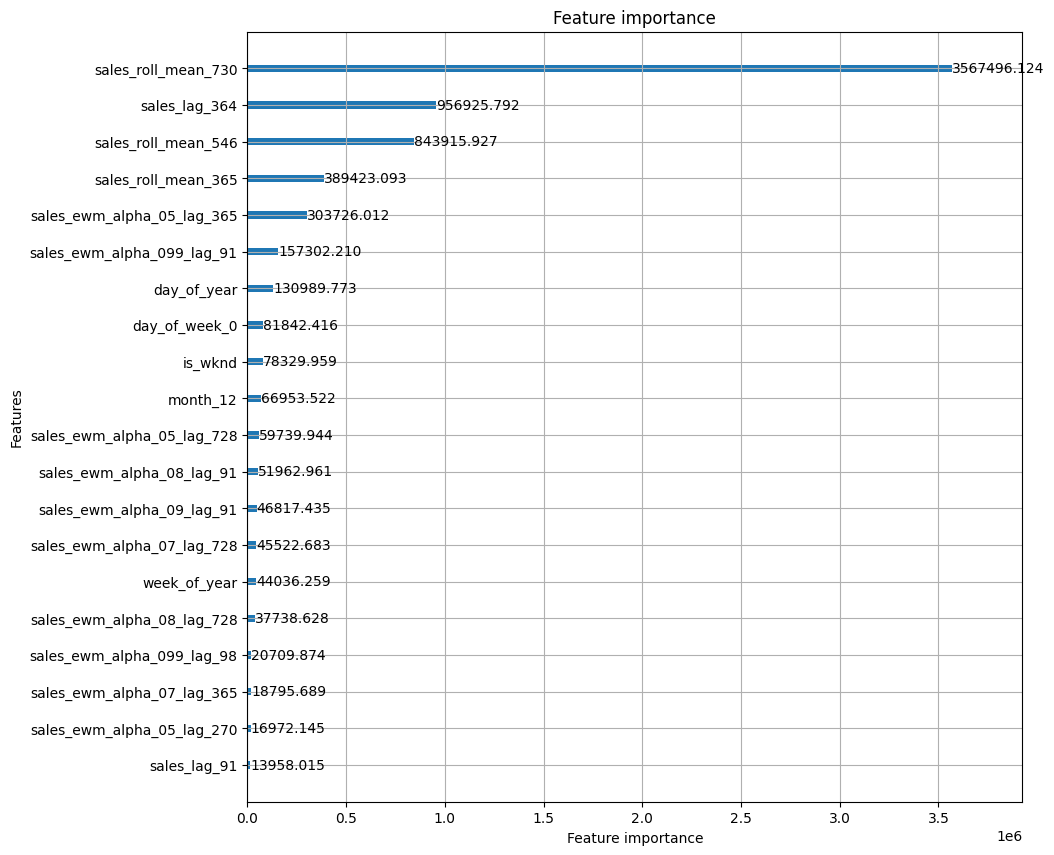

In [63]:
# Feature Importance
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

plot_lgb_importances(model, num=30)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

In [84]:
# Final Model
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## 9. Prediction - Final Result

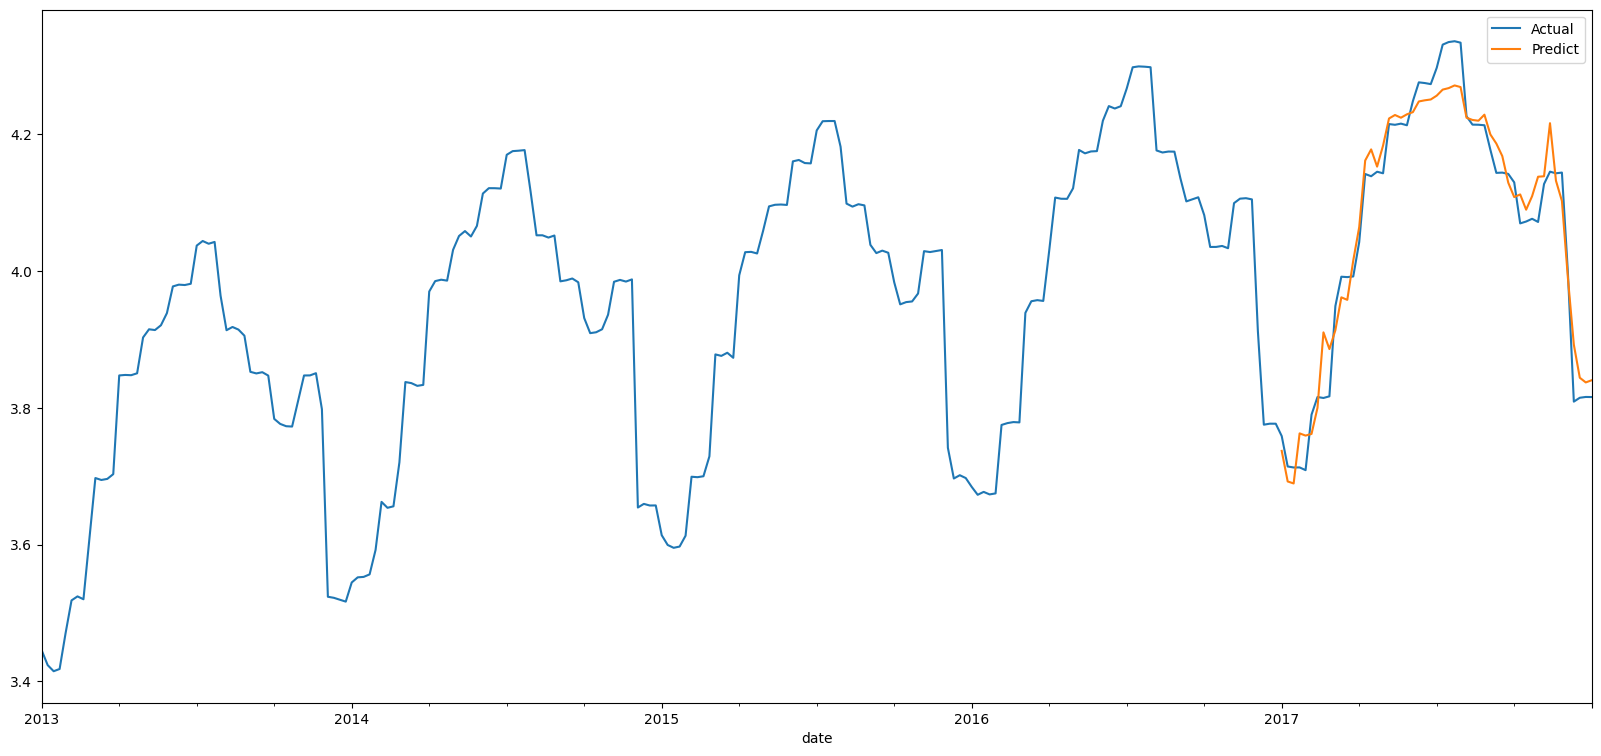

In [85]:
# 1 year actual and predicted values
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

df.set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Actual")
forecast.set_index("date").sales.plot(legend=True, label = "Predict")
plt.show()